# Using Deep Learning on Sensor Time Series Data to Estimate Gait Phase
An independent project by Curtis Gribben

## Table of Contents
- [Overview](#Overview)
 
- [1 Exploratory Data Analysis](#1-Exploratory-Data-Analysis)

- [2 Ingestion, Preprocessing and Initial "Mode" Classification](#2-Ingestion,-Preprocessing-and-Initial-"Mode"-Classification)

- [3 Data Augmentation](#3-Data-Augmentation)

- [4 Training](#4-Training)

- [5 Validation](#5-Validation)

- [6 Iteration](#6-Iteration)

- [Conclusions](#Conclusions)

<!-- [[Overview]] -->
## Overview

### Background

This project represents my attempt at **emulating a functionality developed for an experimental therapeutic device** currently being tested by researchers at Imperial College London. Having come across several papers on the topic, I got in touch with one of the authors to enquire about the technology used here, telling them that I wanted to understand and recreate the technology. 

Fortunately, they were happy to outline the theory behind the device and the data used for training it - below is a brief summary of the device and the challenge I set myself...

### The Device

The intended use of the device is **to reduce stress on the knee joint in osteoarthritis patients as well as recovering athletes**. In order to achieve this, **Functional Electrical Stimulation (FES) is applied to a muscle in the leg at certain key  points during movement**. This has been shown to reduce certain forces on the knee compared to movement without FES:

"The BioStim device incorporates **motion sensors, an embedded machine learning model and electrodes into a wearable device**, providing a platform for the modification of the muscle contractions of a patient in real time during rehabilitation."

Crucially, FES is only beneficial here if applied at a certain point in the person's stride. The embedded model mentioned above plays a crucial role within the device, in that it **estimates the current gait phase in real-time, and thus enables the device to administer FES at the correct point within the gait:**

"Motion data, sampled at 500Hz, form a continuous stream of input to the onboard ML model which generates, for every new sample, a scalar integer output corresponding to the current gait phase of the patient, "p". p is used to determine the onset and offset of neuromuscular stimulation."

The below figure demonstrates how the device works:
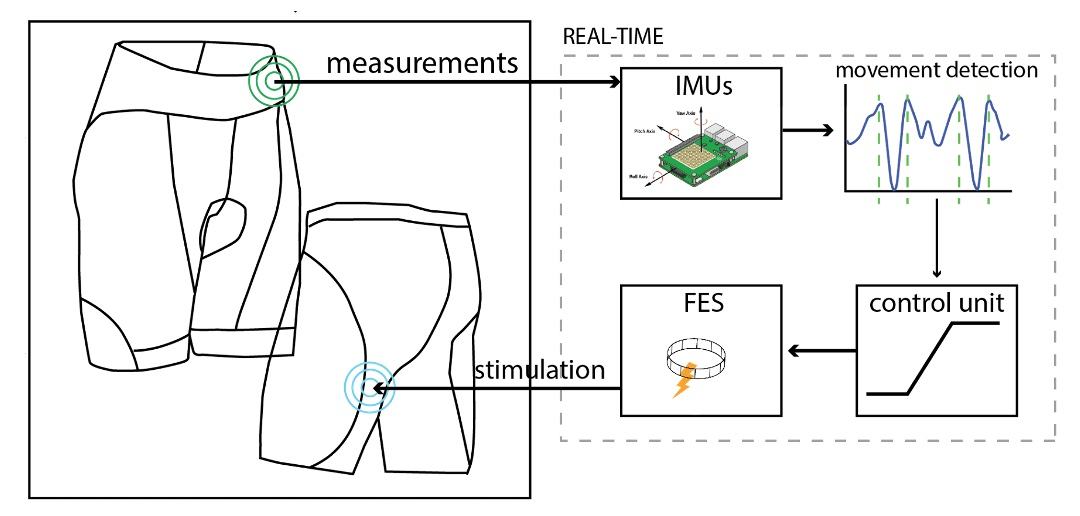

### Project Aim

The aim of this project is to **recreate the embedded model** (as used in the "control unit", labelled above) which uses **onboard movement sensor data to estimate the gait phase of a person wearing the device at time "t"**.

The dataset I will use to do so is detailed below.

### The Dataset

**Although unable to supply the full dataset used for training the device, the authors were able to send me a small subset of the data used. Therefore, the focus of this project is to write code which is able to scale to a larger dataset; thus, the overall fidelity of the models created here is not overly important.**

The dataset comprises **6 CSV files, taken from 5 subjects**. Filenames are provided in the format 'ID_ACTIVITY.csv' where ID is a three digit subject identifier and ACTIVITY denotes the activity recorded; 'walk' = walking, 'jog' = jogging, 'var' = various. **All recordings were taken at 500Hz**. Note that a broad range of different walking and running speeds is represented. Each CSV represents a single contiguous recording with the arrow of time running from top to bottom. Each row represents the data sampled at a given timepoint - the interval between successive rows is 1000/500 = 2ms.

The gait cycle is defined with reference to a given limb - left or right - and comprises stance phase (from the moment of heelstrike to the moment of toe-off) and swing phase (from toe-off to subsequent heelstrike); see the figure below. Stance and swing phase are further subdivided into 6 phases, **giving 12 phases in total so that the gait phase p lies in the interval (0,11)**.

**The phases are numbered consecutively from the start of stance to the end of swing**. Phases 0-5 inclusive make up stance, with phase 0 representing the period immediately following heel-strike. Phases 6-11 make up swing, with phase 11 representing the period immediately preceding heelstrike.

The modelling task is to predict this scalar integer using the sensor data as input. That is, using any of the sensor data available up to and including (but not beyond) time t, predict the gait phase at time t.

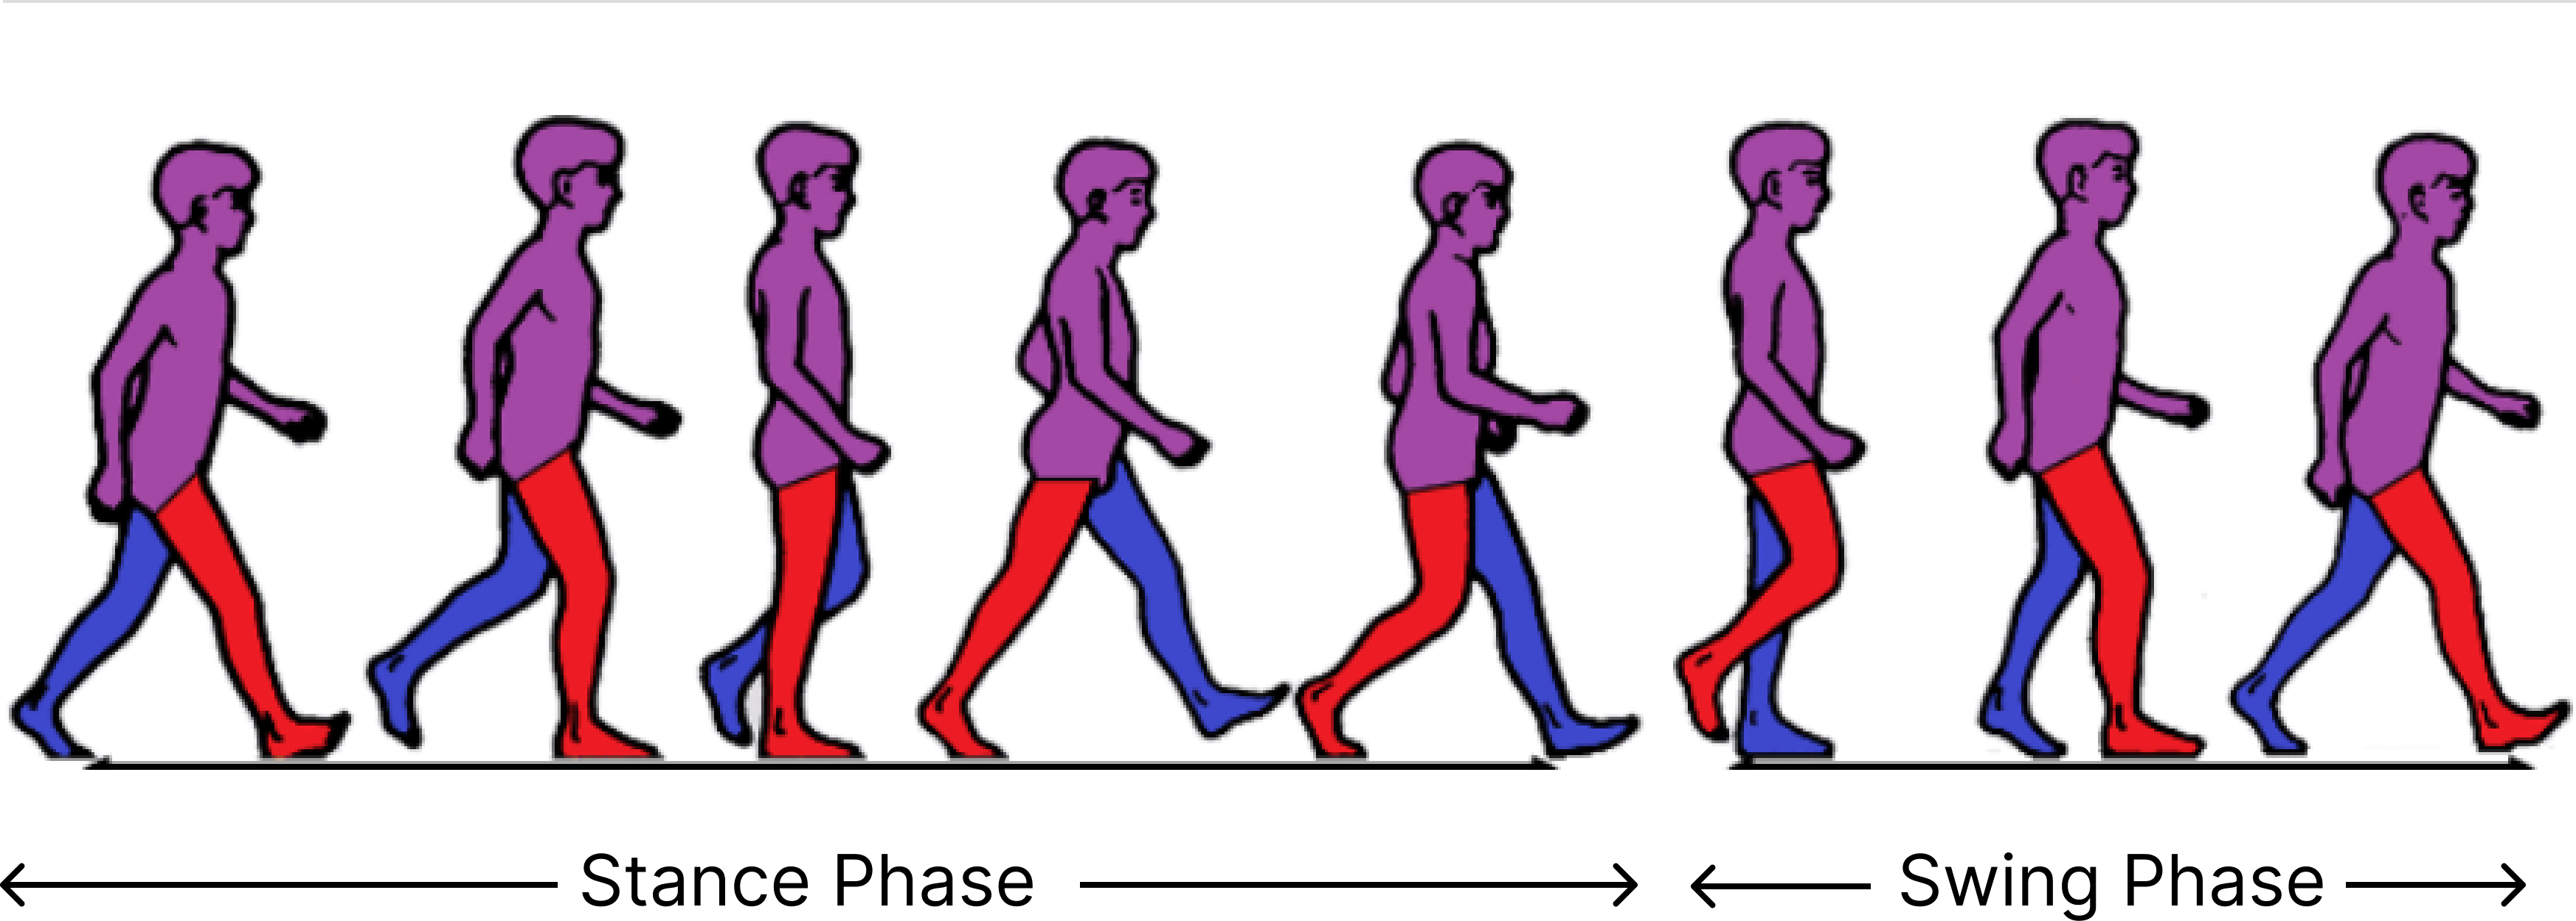

#### Features
Features are recorded from two motion sensors embedded in the device. Left and right are defined from the subject's point of view. Linear accelerations are given in 𝑚/𝑠^2; angular velocities are in  𝑑𝑒𝑔𝑟𝑒𝑒𝑠/𝑠.

- acc_x_left: x-component of linear acceleration from left sensor
- acc_y_left: y-component of linear acceleration from left sensor
- acc_z_left: z-component of linear acceleration from left sensor
- gyr_x_left: x-component of angular velocity from left sensor
- gyr_y_left: y-component of angular velocity from left sensor
- gyr_z_left: z-component of angular velocity from left sensor
- acc_x_right: x-component of linear acceleration from right sensor
- acc_y_right: y-component of linear acceleration from right sensor
- acc_z_right: z-component of linear acceleration from right sensor
- gyr_x_right: x-component of angular velocity from right sensor
- gyr_y_right: y-component of angular velocity from right sensor
- gyr_z_right: z-component of angular velocity from right sensor

#### Label
left_phase: Integer in the interval (0,11)
  corresponding to the gait phase of the left leg of the subject. Data for the right leg are not provided.

#### Constraints
In the embedded environment, severe constraints exist on available compute and memory. For the purposes of this exercise, I disregard these constraints.

## My Approach

#### Model choice
I have opted to leverage the power that CNNs show in extracting useful features from time series data in order to carry out this classification task.

#### Method
- First build and train a movement mode classifier using ".csv" names to infer mode class.

- Use this mode classifier to split "walk" and "jog" to train separate models (important for automated classification of "var" time series).

- **During prediction, one will pass each sample through the "mode" classifier before feeding it into the relevant "phase" classifier for optimized specificity.**

#### Caveats
- Due to low sample diversity, classifier doesn't work very well on unseen data (i.e., on "var" trials). This would be ameliorated with data from more participants.

- Having been trimmed from 136 to 94, not all "jog" data is used for training. This would be mitigated by adding more data - if not practically, then artificially by introducing overlap (say 50%) in timestep windows (see proposed implementation below...).

In [ ]:
#overlap = timesteps/2

#stride = timesteps - overlap
  
#batches = []
  
#for i in range(0, len(df), stride):

    #batch = df.iloc[i:i+timesteps]
    #batches.append(batch)

#batches = [batch for batch in batches if len(batch) == timesteps]
  
#df = pd.concat(batches, ignore_index=True)

### Loading Dependencies and Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore, t
from sklearn.model_selection import train_test_split # sklearn = 1.2.1
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import backend as K

In [ ]:
csv_files = ["004_jog.csv", "009_walk.csv", "011_var.csv", "014_var.csv", "017_jog.csv", "017_walk.csv"]

<!-- [[Exploratory Data Analysis]] -->
## 1 Exploratory Data Analysis

#### Feature Engineering

Firstly, I have converted both accelerometer and gyroscope components to their additive magnitudes - this was done according to the following formulae:

"Mag Acc" = sqrt(acc_x^2 + acc_y^2 + acc_z^2)

"Mag Vel" = sqrt(gyr_x^2 + gyr_y^2 + gyr_z^2)

This was done to mitigate any variance in the dataset which might come from differential sensor positioning/orientation between trials. Additionally, taking these 4 engineered features in place of the 12 original features reduces dimensionality, whilst hopefully preserving important signal.

In the following, I have generally chosen to show just Mag Acc (left foot), assuming similar trends apply across the other magnitudinal features. This is done for the sake of brevity and conciseness.

#### Plotting Mag Acc (left) for the different time series
Mean and Std are also shown for each time series.

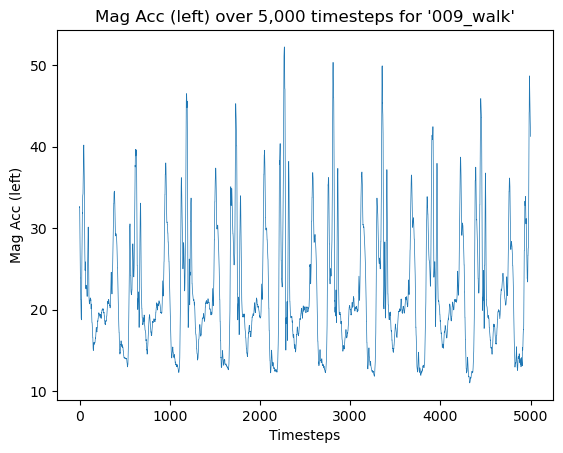

Mean '009_walk': 22.32
Std '009_walk': 8.22


In [226]:
df = pd.read_csv("009_walk.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5 # Deriving Mag Acc feature from x, y, and z components

plt.plot(range(5000), df["mag_acc_left"][5000:10000], linewidth=0.5)
plt.title("Mag Acc (left) over 5,000 timesteps for '009_walk'")
plt.xlabel("Timesteps")
plt.ylabel("Mag Acc (left)")
plt.show()
print(f"Mean '009_walk': {round(np.mean(df['mag_acc_left']), 2)}")
print(f"Std '009_walk': {round(np.std(df['mag_acc_left']), 2)}")

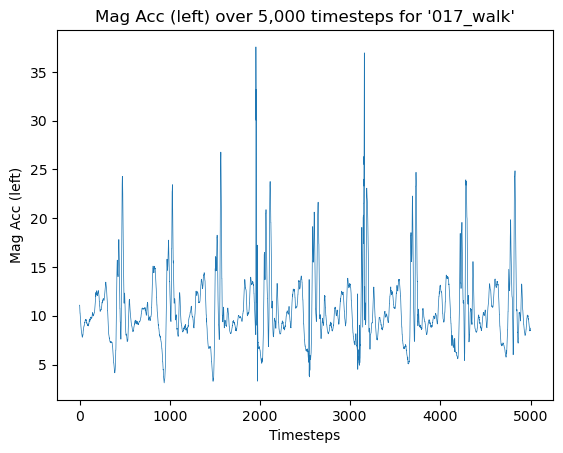

Mean '017_walk': 10.84
Std '017_walk': 4.02


In [227]:
df = pd.read_csv("017_walk.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

plt.plot(range(5000), df["mag_acc_left"][5000:10000], linewidth=0.5)
plt.title("Mag Acc (left) over 5,000 timesteps for '017_walk'")
plt.xlabel("Timesteps")
plt.ylabel("Mag Acc (left)")
plt.show()
print(f"Mean '017_walk': {round(np.mean(df['mag_acc_left']), 2)}")
print(f"Std '017_walk': {round(np.std(df['mag_acc_left']), 2)}")

At this point we can compare the characteristics of both "walk" time series. 

Both differ greatly in both mean (22.32 vs 10.84) and std (8.22 vs 4.02). 

It is clear, then, that different individuals (or at least movement speeds) can express drastically different gait dynamics, within the same mode of movement.

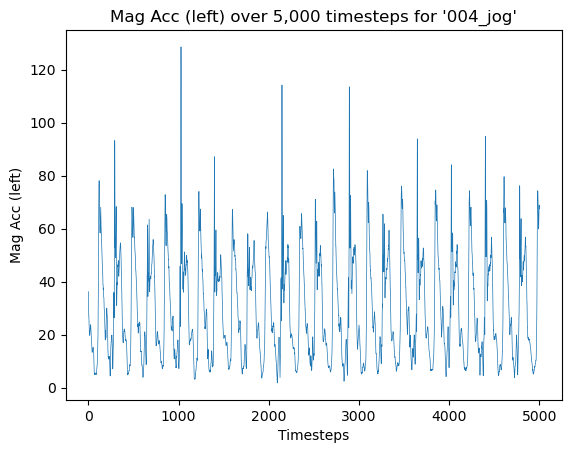

Mean '004_jog': 32.34
Std '004_jog': 19.26


In [228]:
df = pd.read_csv("004_jog.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

plt.plot(range(5000), df["mag_acc_left"][5000:10000], linewidth=0.5)
plt.title("Mag Acc (left) over 5,000 timesteps for '004_jog'")
plt.xlabel("Timesteps")
plt.ylabel("Mag Acc (left)")
plt.show()
print(f"Mean '004_jog': {round(np.mean(df['mag_acc_left']), 2)}")
print(f"Std '004_jog': {round(np.std(df['mag_acc_left']), 2)}")

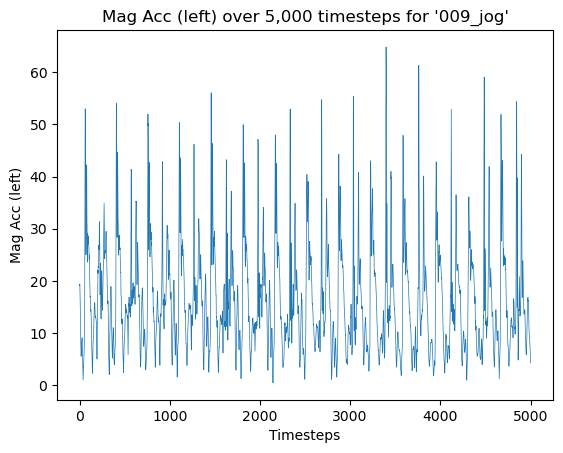

Mean '017_jog': 16.37
Std '017_jog': 10.48


In [229]:
df = pd.read_csv("017_jog.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

plt.plot(range(5000), df["mag_acc_left"][5000:10000], linewidth=0.5)
plt.title("Mag Acc (left) over 5,000 timesteps for '009_jog'")
plt.xlabel("Timesteps")
plt.ylabel("Mag Acc (left)")
plt.show()
print(f"Mean '017_jog': {round(np.mean(df['mag_acc_left']), 2)}")
print(f"Std '017_jog': {round(np.std(df['mag_acc_left']), 2)}")

Now we can compare "jog" time series both with each other and with "walk" time series.

"Jog", too, exhibits a great deal of variation between trials, in mean (32.34 vs 16.37) as well as std (19.26 vs 10.48).

Furthermore, "walk" and "jog" demonstrate large differences from one another both in mean (16.58 vs 24.36) and std (6.12 vs 14.87) (note that the "jog" time series are different lengths, however the mean of their two means still makes for a useful comparison against that of the "walk" time series).

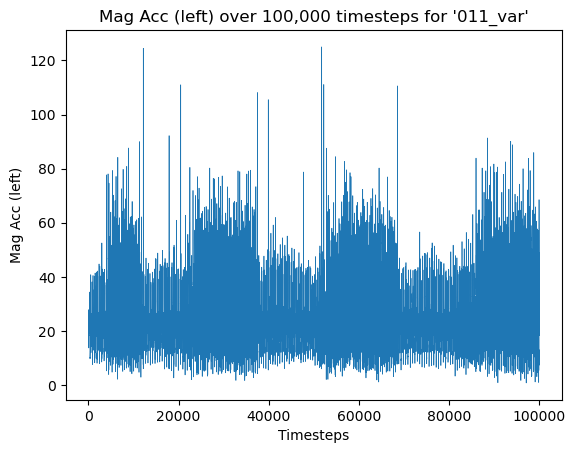

Mean '011_var': 25.74
Std '011_var': 12.53


In [230]:
df = pd.read_csv("011_var.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

plt.plot(range(len(df)), df["mag_acc_left"], linewidth=0.5)
plt.title("Mag Acc (left) over 100,000 timesteps for '011_var'")
plt.xlabel("Timesteps")
plt.ylabel("Mag Acc (left)")
plt.show()
print(f"Mean '011_var': {round(np.mean(df['mag_acc_left']), 2)}")
print(f"Std '011_var': {round(np.std(df['mag_acc_left']), 2)}")

Here, taking a larger window, we can see visualized the variation in modes of movement within a "var" time series.

#### Investigating the cyclical trends of "walk" and "jog"

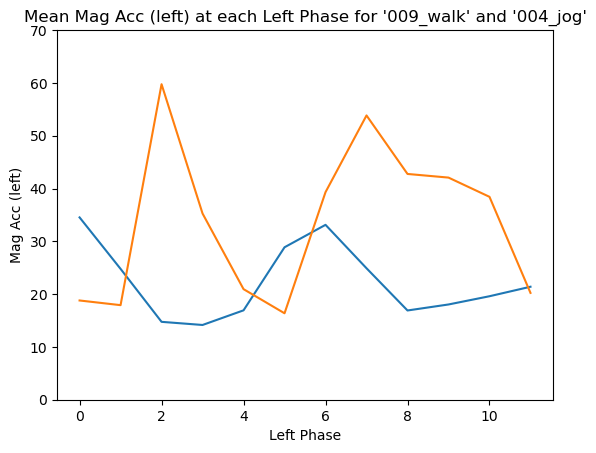

In [231]:
df = pd.read_csv("009_walk.csv").iloc[:, 1:]
df1 = pd.read_csv("004_jog.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5
df1["mag_acc_left"] = (df1["acc_x_left"]**2 + df1["acc_y_left"]**2 + df1["acc_z_left"]**2)**0.5

phase_means_walk = []
phase_means_jog = []

for i in set(df["left_phase"].unique()):
    phase_means_walk.append(np.mean(df["mag_acc_left"][df["left_phase"] == i]))
    phase_means_jog.append(np.mean(df1["mag_acc_left"][df1["left_phase"] == i]))

plt.plot(range(len(phase_means_walk)), phase_means_walk)
plt.plot(range(len(phase_means_jog)), phase_means_jog)
plt.ylim(0, 70)
plt.ylabel('Mag Acc (left)')
plt.xlabel('Left Phase')
plt.title("Mean Mag Acc (left) at each Left Phase for '009_walk' and '004_jog'")
plt.show()

Here we observe the general trend outlines of Mag Acc (left) for "009_walk" and "004_jog".

Below, we expand upon this visualization with boxplots.

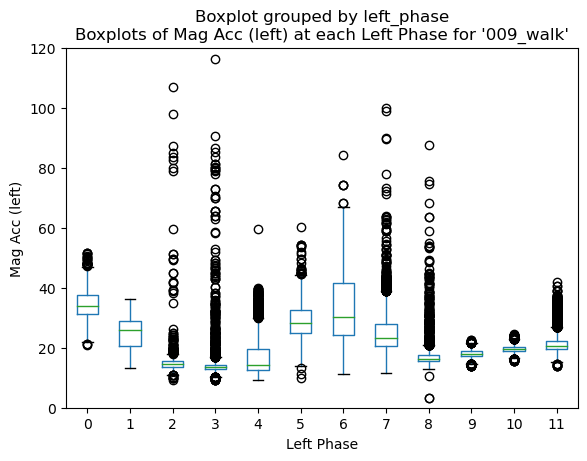

In [232]:
df = pd.read_csv("009_walk.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

df.boxplot(column='mag_acc_left', by='left_phase', grid=False)
plt.ylim(0,120)
plt.ylabel("Mag Acc (left)")
plt.xlabel("Left Phase")
plt.title("Boxplots of Mag Acc (left) at each Left Phase for '009_walk'")
plt.show()

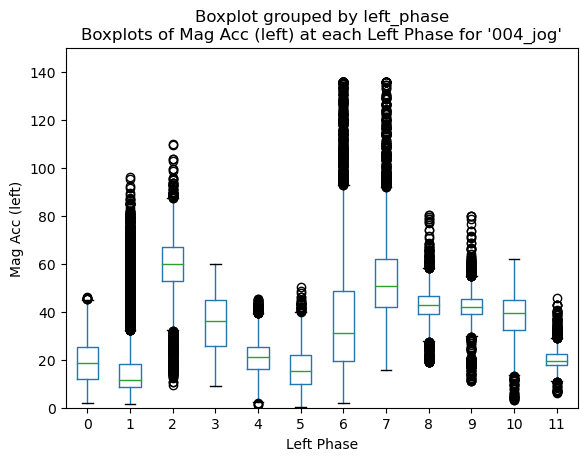

In [233]:
df = pd.read_csv("004_jog.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

df.boxplot(column='mag_acc_left', by='left_phase', grid=False)
plt.ylim(0,150)
plt.ylabel("Mag Acc (left)")
plt.xlabel("Left Phase")
plt.title("Boxplots of Mag Acc (left) at each Left Phase for '004_jog'")
plt.show()

Looking at the two plots above, we can see that "walk" and "jog" differ in the overall shape of their trends.

There are different events occurring in the same phase between the two modes of movement.

This will likely lead to challenges when it comes to classification. For example, a certain peak observed could be characteristic of phase "x" in "walk", but also of phase "y" in "jog".

Therefore, the existence of different modes of movement in the data represents a problem which we need to resolve. This is what I set out to do later during model construction.

#### Plotting single strides along with stride phase

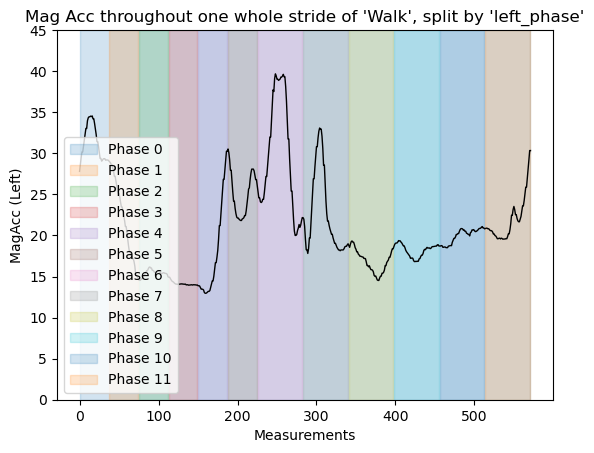

In [208]:
df = pd.read_csv("009_walk.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

stride = df[5371:5943] # Slicing to the beginning of a stride far from the start of the trial to ensure we get a representative stride
stride = stride.reset_index(drop=True)

x_values = range(len(stride))


fig, ax1 = plt.subplots()
ax1.plot(x_values, stride["mag_acc_left"], color='black', linewidth=1)
plt.ylim(0, 45)
ax1.set_xlabel('Measurements')
ax1.set_ylabel('MagAcc (Left)', color='black')
ax1.tick_params('y', colors='black')

for phase in range(max(stride["left_phase"])+1):
    phase_indices = stride.index[stride["left_phase"] == phase]
    plt.fill_between(phase_indices, 0, 45,
                     color=f'C{phase}', alpha=0.2, label=f'Phase {phase}')

plt.title("Mag Acc throughout one whole stride of 'Walk', split by 'left_phase'")
plt.legend()
plt.show()

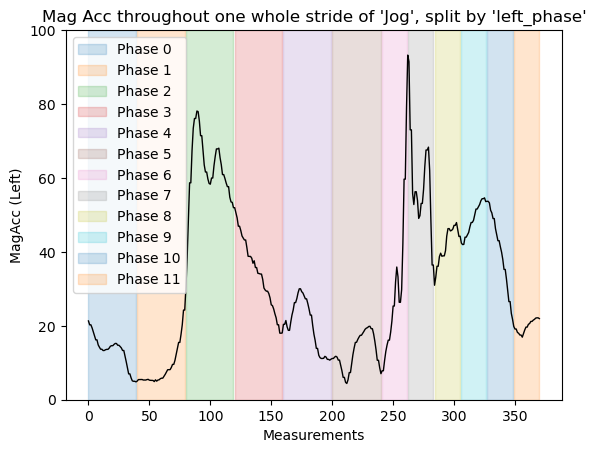

In [209]:
df = pd.read_csv("004_jog.csv").iloc[:, 1:]

df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5

stride = df[5029:5400]
stride = stride.reset_index(drop=True)

x_values = range(len(stride))


fig, ax1 = plt.subplots()
ax1.plot(x_values, stride["mag_acc_left"], color='black', linewidth=1)
plt.ylim(0, 100)
ax1.set_xlabel('Measurements')
ax1.set_ylabel('MagAcc (Left)', color='black')
ax1.tick_params('y', colors='black')

for phase in range(max(stride["left_phase"])+1):
    phase_indices = stride.index[stride["left_phase"] == phase]
    plt.fill_between(phase_indices, 0, 100,
                     color=f'C{phase}', alpha=0.2, label=f'Phase {phase}')

plt.title("Mag Acc throughout one whole stride of 'Jog', split by 'left_phase'")
plt.legend()
plt.show()

Here we can observe the different trend shapes between "walk" and "jog" time series over the course of a single stride.

Additionally, it is evident that there is a minor degree of class imbalance within the data. We might, therefore, consider remedying this by using an oversampling technique such as SMOTE.

<!-- [[2 Ingestion, Preprocessing and Initial "Mode" Classification]] -->
## 2 Ingestion, Preprocessing and Initial "Mode" Classification

In [235]:
def make_dataset(filenames):
    
    ### Starting off by ingesting data for training of the initial "mode" classifier...
    
    global num_features
    
    timesteps = 136 # Setting the window length for each sample

    X_list = []
    y_list = []
    mode_labels_list = []

    for file in filenames: # Only taking in "walk" or "jog" files at this point; no "var" files

        if file[-8:] == "walk.csv" or file[-7:] == "jog.csv":

            df = pd.read_csv(file).iloc[:, 1:]

            window_size = 3 # Smoothing to enhance generalization

            for column in df.columns[:-1]:
                df[column] = np.convolve(df[column], np.ones(window_size)/window_size, mode='same')    

            df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5 # Deriving magnitude features
            df["mag_acc_right"] = (df["acc_x_right"]**2 + df["acc_y_right"]**2 + df["acc_z_right"]**2)**0.5
            df["mag_vel_left"] = (df["gyr_x_left"]**2 + df["gyr_y_left"]**2 + df["gyr_z_left"]**2)**0.5
            df["mag_vel_right"] = (df["gyr_x_right"]**2 + df["gyr_y_right"]**2 + df["gyr_z_right"]**2)**0.5

            if len(df) % timesteps != 0: # Ensuring df divides into window length (136)
                df = df.iloc[:-(len(df)%timesteps)]

            features = df[["mag_acc_left", "mag_vel_left", "mag_acc_right", "mag_vel_right"]] # Extracting magnitudes

            num_features = len(features.columns)

            features_2d = features.values
            features_3d = features_2d.reshape((timesteps, num_features, -1)) 
            X = np.transpose(features_3d, (2, 0, 1)) # Reshaping to (samples, timesteps, features)

            if file[-8:] == "walk.csv": # Getting "mode" labels using csv file names
                mode_labels = np.repeat(np.array([[1]]), X.shape[0], axis=0)
            elif file[-7:] == "jog.csv":
                mode_labels = np.repeat(np.array([[0]]), X.shape[0], axis=0)

            X_list.append(X) # Adding to all feature data
            mode_labels_list.append(mode_labels) # Adding to all label data

    X_all = np.concatenate(X_list, axis=0) # Concatenating all feature data

    X_all_reshaped = X_all.reshape(-1, num_features) # Standardizing combined samples
    X_all_standardized_reshaped = zscore(X_all_reshaped, axis=0)
    X_all = X_all_standardized_reshaped.reshape(-1, timesteps, num_features)

    mode_labels_all = np.concatenate(mode_labels_list, axis=0) # Concatenating all labels
    mode_labels_all = to_categorical(mode_labels_all) # One-hot encoding labels

    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_all, mode_labels_all, test_size=0.2, random_state=42) # Splitting into train and test sets

    ### Carying out SMOTE for "mode" classifier data (there are currently more "walk" samples than "jog" samples)
    X_train_flat = np.reshape(X_train_pre, (X_train_pre.shape[0], -1))
    smote = SMOTE(random_state=42)
    X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train_pre)
    X_train_resampled = X_train_resampled_flat.reshape((X_train_resampled_flat.shape[0], X_train_pre.shape[1], -1))
    X_train_pre = X_train_resampled
    y_train_pre = y_train_resampled
    y_train_pre = to_categorical(y_train_pre)

    ### Carrying out data augmentation on "mode" classifier data. This will pay dividends given an expanded dataset. Augmentation will be further discussed below when performing it for "phase" classifiers.
    augmented_samples = []

    for original_sample in X_train_pre:

        augmented_samples.append(original_sample)
        augmented_sample = original_sample.copy()
        magnitude_factor = random.uniform(0.5, 2)
        augmented_sample = original_sample*magnitude_factor
        augmented_samples.append(augmented_sample)

    X_train_pre = np.array(augmented_samples)

    y_train_pre = np.repeat(y_train_pre, 2, axis=0) # Duplicating labels to match newly augmented features

    ### Building "mode" CNN classifier
    
    model_pre = Sequential([ 

      Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=(timesteps, num_features)),

      Dropout(0.9),

      BatchNormalization(),

      MaxPooling1D(pool_size=2),

      Conv1D(filters=16, kernel_size=11, activation='relu'),

      Dropout(0.9),

      MaxPooling1D(pool_size=2),

      Flatten(),

      Dense(64, activation='relu'),

      Dense(2, activation='sigmoid')

    ])

    model_pre.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history_pre = model_pre.fit(X_train_pre, y_train_pre, epochs=2, batch_size=32, validation_data=(X_test_pre, y_test_pre), verbose=2)

    ### Data ingestion for building "phase" classifier - this is largely the same code as above...

    X_list = []
    y_list = []

    for file in filenames:

        df = pd.read_csv(file).iloc[:, 1:]

        window_size = 3 

        for column in df.columns[:-1]:
            df[column] = np.convolve(df[column], np.ones(window_size)/window_size, mode='same')    

        df["mag_acc_left"] = (df["acc_x_left"]**2 + df["acc_y_left"]**2 + df["acc_z_left"]**2)**0.5
        df["mag_acc_right"] = (df["acc_x_right"]**2 + df["acc_y_right"]**2 + df["acc_z_right"]**2)**0.5
        df["mag_vel_left"] = (df["gyr_x_left"]**2 + df["gyr_y_left"]**2 + df["gyr_z_left"]**2)**0.5
        df["mag_vel_right"] = (df["gyr_x_right"]**2 + df["gyr_y_right"]**2 + df["gyr_z_right"]**2)**0.5

        if len(df) % timesteps != 0:
            df = df.iloc[:-(len(df)%timesteps)]

        features = df[["mag_acc_left", "mag_vel_left", "mag_acc_right", "mag_vel_right"]]

        num_features = len(features.columns)

        features_2d = features.values
        features_3d = features_2d.reshape((timesteps, num_features, -1))
        X = np.transpose(features_3d, (2, 0, 1))

        labels = to_categorical(df["left_phase"]) # Extracting "phase" labels

        y = labels[::timesteps] # Lining up each label with the last timestep (t) of each window

        X_list.append(X)
        y_list.append(y)

    X_all = np.concatenate(X_list, axis=0)

    X_all_reshaped = X_all.reshape(-1, num_features) # Standardizing combined samples - during implementation, future samples will be standardized using the parameters established here before prediction. Note that in an ideal world, these parameters will be the same between the "mode" classification training dataset and the full "phase" classification dataset (as we should have attained parameters representative of the population), although here, in this limited sample, they will be those of just the "walk" and "jog" files, and of all files, respectively.
    X_all_standardized_reshaped = zscore(X_all_reshaped, axis=0)
    X_all = X_all_standardized_reshaped.reshape(-1, timesteps, num_features)

    y_all = np.concatenate(y_list, axis=0)

    ### Using "mode" classifier to sort samples into "walk" or "jog"
    
    predictions = model_pre.predict(X_all) # Making predictions
    predictions = (predictions > 0.5).astype(int)

    walk = [] # Assorting samples based on their predictions
    jog = []
    walk_labels = []
    jog_labels = []

    for i in range(len(predictions)):

        if predictions[i][0] == 0:
            walk.append(X_all[i])
            walk_labels.append(y_all[i])
        elif predictions[i][0] == 1:
            jog.append(X_all[i])
            jog_labels.append(y_all[i])

    walk = np.concatenate((walk), axis=0)
    jog = np.concatenate((jog), axis=0)
    walk_labels = np.array(walk_labels)
    jog_labels = np.array(jog_labels)

    walk = walk.reshape(-1, 136, 4)
    jog = jog.reshape(-1, 136, 4)

    ### Trimming each 136 timestep sequence for "jog" to 94 timesteps (the optimum window based on preliminary results from the two "jog.csv"s supplied here)
    trimmed_jog_data = []

    for i in jog:
        trimmed_window = i[-94:]
        trimmed_jog_data.append(trimmed_window)

    jog = np.array(trimmed_jog_data)

    X_train_walk, X_temp, y_train_walk, y_temp = train_test_split(walk, walk_labels, test_size=0.3, random_state=42) # Carrying out a 70/15/15 split
    X_val_walk, X_test_walk, y_val_walk, y_test_walk = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train_jog, X_temp, y_train_jog, y_temp = train_test_split(jog, jog_labels, test_size=0.3, random_state=42)
    X_val_jog, X_test_jog, y_val_jog, y_test_jog = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return (X_train_walk, y_train_walk, X_val_walk, y_val_walk, X_test_walk, y_test_walk, X_train_jog, y_train_jog, X_val_jog, y_val_jog, X_test_jog, y_test_jog)

<!-- [[3 Data Augmentation]] -->
## 3 Data Augmentation

In [236]:
def make_augmented_dataset(filenames):
    
    ### Data augmentation - doesn't help here with the provided training set because of the extreme low sample diversity (also the case with SMOTE); variations/interpolations don't necessarily map onto something the model might expect to see in the test set, thus may actually reduce performance, given the current datasets available. For the purposes of this project (for extrapolation to use on more data), I have left augmentation in, with the parameters set at a moderate/high level. This does negatively impact accuracy here however - to the point where "model_jog" has little/no predictive power.
    ### Here, I opted for amplitude/magnitude scaling. Note that due to version compatibility issues, I couldn't import the "albumentations" package to use its AmplitudeScale class. Therefore, I opted instead to carry out the transformation manually.
    
    ### Instantiating the required variables using "make_dataset()", as defined above
    
    (X_train_walk, y_train_walk, X_val_walk, y_val_walk, X_test_walk, y_test_walk, X_train_jog, y_train_jog, X_val_jog, y_val_jog, X_test_jog, y_test_jog) = make_dataset(filenames)

    augmented_samples = []

    for original_sample in X_train_walk:

        augmented_samples.append(original_sample)
        augmented_sample = original_sample.copy()
        magnitude_factor = random.uniform(0.75, 1.5) # Magnitude will be scaled by a factor between 0.75 and 1.5, chosen randomly from a uniform distribution
        augmented_sample = original_sample * magnitude_factor
        augmented_samples.append(augmented_sample)

    X_train_walk = np.array(augmented_samples)

    y_train_walk = np.repeat(y_train_walk, 2, axis=0) # Labels duplicated to match new number of features


    augmented_samples = [] # Doing the same for "jog"

    for original_sample in X_train_jog:

        augmented_samples.append(original_sample)
        augmented_sample = original_sample.copy()
        magnitude_factor = random.uniform(0.75, 1.5)
        augmented_sample = original_sample * magnitude_factor
        augmented_samples.append(augmented_sample)

    X_train_jog = np.array(augmented_samples)

    y_train_jog = np.repeat(y_train_jog, 2, axis=0)
    
    return (X_train_walk, y_train_walk, X_val_walk, y_val_walk, X_test_walk, y_test_walk, X_train_jog, y_train_jog, X_val_jog, y_val_jog, X_test_jog, y_test_jog)

<!-- [[4 Training]] -->
## 4 Training

In [237]:
def build_model():
    
    ### Instantiating the required variables using "make_augmented_dataset()", as defined above
    
    (X_train_walk, y_train_walk, X_val_walk, y_val_walk, X_test_walk, y_test_walk, X_train_jog, y_train_jog, X_val_jog, y_val_jog, X_test_jog, y_test_jog) = make_augmented_dataset(csv_files)

    model_walk = Sequential([
  
        Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(136, num_features)),

        BatchNormalization(),

        Conv1D(filters=64, kernel_size=11, activation='relu'),

        Dropout(0.5),

        MaxPooling1D(pool_size=2),

        Flatten(),

        Dense(64, activation='relu'),

        Dropout(0.5),

        Dense(32, activation='relu'),

        Dense(12, activation='softmax')

        ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Implementing early stopping with patience of 15

    model_walk.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model_walk.fit(X_train_walk, y_train_walk, epochs=200, batch_size=32, validation_data=(X_val_walk, y_val_walk), callbacks=[early_stopping], verbose=2)
    
    
    clear_session() # Clearing GPU space between training of models
    
    
    model_jog = Sequential([
  
        Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(94, num_features)),

        BatchNormalization(),

        Conv1D(filters=64, kernel_size=11, activation='relu'),

        Dropout(0.5),

        MaxPooling1D(pool_size=2),

        Flatten(),

        Dense(64, activation='relu'),

        Dropout(0.5),

        Dense(32, activation='relu'),

        Dense(12, activation='softmax')

        ])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # Implementing early stopping with patience of 30 (to give it more of a chance to learn)
    
    model_jog.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model_jog.fit(X_train_jog, y_train_jog, epochs=200, batch_size=32, validation_data=(X_val_jog, y_val_jog), callbacks=[early_stopping], verbose=2)
    
    return (model_walk, model_jog, X_test_walk, y_test_walk, X_test_jog, y_test_jog) # Returns test sets as well for validation stage

<!-- [[5 Validation]] -->
## 5 Validation

In [238]:
def train_and_validate(n):
    
    ### Here I attain the mean model accuracy over "n" steps of ingestion, training, and test set evaluation. In each step, "walk" and "jog" model accuracies are combined and averaged, with a weighting of their corresponding test set sample size. This, therefore, reflects the accuracy of the full integrated model during prediction.
    
    trial_accuracies = []
    
    for i in range(n):

        (model_walk, model_jog, X_test_walk, y_test_walk, X_test_jog, y_test_jog) = build_model() # Building models, also returning test sets

        walk_accuracy = model_walk.evaluate(X_test_walk, y_test_walk)[1] # Returning "walk" model accuracy
        jog_accuracy = model_jog.evaluate(X_test_jog, y_test_jog)[1] # Returning "jog" model accuracy

        weighted_accuracy = walk_accuracy*(len(X_test_walk)/(len(X_test_walk)+len(X_test_jog))) + jog_accuracy*(len(X_test_jog)/(len(X_test_walk)+len(X_test_jog))) # Getting weighted average accuracy

        trial_accuracies.append(weighted_accuracy) # Adding accuracy of this trial to the list of all trial accuracies
        
    mean_acc = np.mean(trial_accuracies) # This is the full integrated model accuracy, attained from "n" trials of ingestion, training, and test set evaluation
    
    if n > 1: # Getting t-distribution error margins for model accuracy (0.95% level)
        
        std_dev = np.std(trial_accuracies, ddof=1)  # ddof = 1 for sample standard deviation
        num_trials = len(trial_accuracies)

        t_score = t.ppf((1 + 0.95)/2, df=num_trials-1)
        error_margin = t_score * (std_dev / np.sqrt(num_trials))
        
        return f"Overall Model Test Accuracy: {round(100*mean_acc, 2)}% +/- {round(100*error_margin, 2)}%" # Printing accuracy
    
    else:
        
        return f"Overall Model Test Accuracy: {round(100*mean_acc, 2)}%" # Printing accuracy if just "n = 1" is passed into validation function

Note that using just each pair of "walk" and "jog" files, I achieved test accuracies of around 75% and 72%, respectively.
Both model accuracies are now lower because of dilution with poorly-labelled "var" data (again, due to the limited data here).

This drop in accuracy comes because each mode is best analysed in a certain window length (136 timesteps for "walk" and 94 for "jog"), and sending the wrong mode to the wrong model will lead to a near random prediction.

Additionally, "jog" accuracy is lowered further because of the trimming necessary during the process (again, this can be ameliorated by adding more data).

<!-- [[6 Iteration]] -->
## 6 Iteration

I was informed that **in practice, some of the model's errors are more costly than others** -  "Generally, when the model is wrong, it introduces a timing offset between the desired start or end of stimulation, and the actual start or end of stimulation. **The greater the magnitude of this offset, the more costly the error**".

Therefore, I decided to **change my model in order to take into account this differential cost**, implementing these changes as part of a modified training/validation routine.

The approach I took in doing this was to augment the **loss function** - this is detailed in the comments throughout the cell below.

Note that here I am assuming that, in expectation, all gait phases are equally likely to be chosen for stimulation.

In [241]:
def train_and_validate_2(n):
    
    ### Here, I built a custom loss function which confers circular/cyclical ordinality onto the "phase" classes. Non-zero predicted probabilities for each class are weighted more heavily, and thus more strictly penalised, the farther away they are from the true class index.
    ### The code is mostly the same as above, so I will just comment on the changes...
    
    def build_model_2():
    
        (X_train_walk, y_train_walk, X_val_walk, y_val_walk, X_test_walk, y_test_walk, X_train_jog, y_train_jog, X_val_jog, y_val_jog, X_test_jog, y_test_jog) = make_augmented_dataset(csv_files)


        def cyclical_loss(y_true, y_pred): # Defining custom loss function, "cyclical_loss"
    
            total_loss = 0

            true_index = K.cast(K.argmax(y_true, axis=-1), dtype=K.floatx()) # Returning index of "true" class

            for i in range(K.int_shape(y_pred)[-1]): # Iterating through indices of predicted class probabilities

                distance_clockwise = (true_index - i + 12) % 12 # Calculating both clockise and anti-clockwise distance between indices
                distance_anticlockwise = (i - true_index + 12) % 12
                min_distance = K.minimum(distance_clockwise, distance_anticlockwise) # Returning minimum circular distance between indices

                total_loss += min_distance * y_pred[:, i] # Weighting each predicted class probability by circular distance from "true" class, adding to total loss

            return K.sum(total_loss, axis=-1) # Returning total loss


        model_walk = Sequential([

            Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(136, num_features)),

            BatchNormalization(),

            Conv1D(filters=64, kernel_size=11, activation='relu'),

            Dropout(0.5),

            MaxPooling1D(pool_size=2),

            Flatten(),

            Dense(64, activation='relu'),

            Dropout(0.5),

            Dense(32, activation='relu'),

            Dense(12, activation='softmax')

            ])

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        model_walk.compile(loss=cyclical_loss, optimizer='adam', metrics=['accuracy']) # Implementing the custom "cyclical_loss" function

        history = model_walk.fit(X_train_walk, y_train_walk, epochs=200, batch_size=32, validation_data=(X_val_walk, y_val_walk), callbacks=[early_stopping], verbose=2)


        clear_session()


        model_jog = Sequential([

            Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(94, num_features)),

            BatchNormalization(),

            Conv1D(filters=64, kernel_size=11, activation='relu'),

            Dropout(0.5),

            MaxPooling1D(pool_size=2),

            Flatten(),

            Dense(64, activation='relu'),

            Dropout(0.5),

            Dense(32, activation='relu'),

            Dense(12, activation='softmax')

            ])

        early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

        model_jog.compile(loss=cyclical_loss, optimizer='adam', metrics=['accuracy']) # And again for "jog"

        history = model_jog.fit(X_train_jog, y_train_jog, epochs=200, batch_size=32, validation_data=(X_val_jog, y_val_jog), callbacks=[early_stopping], verbose=2)

        return (model_walk, model_jog, X_test_walk, y_test_walk, X_test_jog, y_test_jog)
    
    
    
    trial_accuracies = []
    
    for i in range(n):

        (model_walk, model_jog, X_test_walk, y_test_walk, X_test_jog, y_test_jog) = build_model_2()

        walk_accuracy = model_walk.evaluate(X_test_walk, y_test_walk)[1]
        jog_accuracy = model_jog.evaluate(X_test_jog, y_test_jog)[1]

        weighted_accuracy = walk_accuracy*(len(X_test_walk)/(len(X_test_walk)+len(X_test_jog))) + jog_accuracy*(len(X_test_jog)/(len(X_test_walk)+len(X_test_jog)))

        trial_accuracies.append(weighted_accuracy)
        
    mean_acc = np.mean(trial_accuracies)
    
    if n > 1:
        
        std_dev = np.std(trial_accuracies, ddof=1)
        num_trials = len(trial_accuracies)

        t_score = t.ppf((1 + 0.95)/2, df=num_trials-1)
        error_margin = t_score * (std_dev / np.sqrt(num_trials))
        
        return f"Overall Model Test Accuracy: {round(100*mean_acc, 2)}% +/- {round(100*error_margin, 2)}%"
    
    else:
        
        return f"Overall Model Test Accuracy: {round(100*mean_acc, 2)}%"

Accuracy generally drops a little having implemented the custom loss function - this drop in overall accuracy will come as a trade-off for the reduction in costly misclassifications.

<!-- [[Conclusions]] -->
## Conclusions
**Most accuracy is lost in the "pre" mode classifier, due to low sample diversity here** (it is effectively 50% accuracy on the "var" files, leading to dilution with poorly-labelled samples). As already mentioned, **performance will drastically improve given more participant trial data**.

Further to this effect, accuracy of the "jog" model was significantly lowered by the fact that sample window lengths had to be **trimmed from 136 to 94** to attain the optimum for the mode. Once again, **this can be remedied by adding more samples** (either practically or by introducing overlap in sampling) - this should then result in the optimal model.

Again worth mentioning is that following training on just "walk" and "jog" csv files, my two phase classifier models returned preliminary **test accuracies of around 75% and 72%, respectively**. This is testament to the potential of the model built here, **given an expanded dataset**.

## Thank you for reading!